# Lagrangian Jacobian optimization

## Import statements

In [151]:
%load_ext autoreload
%autoreload 2

# 3rd party imports
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(linewidth=1000)
from scipy.sparse.linalg import lgmres
import sympy as sp


# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up A $\phi$ = B case
Set up an example A*$\phi$ = B problem where there are negative Jacobian determinant values

In [152]:
# Create some example correspondence points
msample = np.array([  # Moving points
    [0, 0, 1],
    [0, 2, 1],
    [0, 2, 0],
])
fsample = np.array([  # Fixed points
    [0, 0, 2],
    [0, 2, 2],
    [0, 1, 1],
])
fixed_sample = np.zeros((1, 3, 3))  # Size of the fixed image

#############################################################################

# Create a Laplacian matrix from the sample set of correspondence points
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
Adense = A.toarray()

z, y, x = (0, 1, 1)  # Preview test index
laplacian_idx = laplacian.get_laplacian_index(z, y, x, fixed_sample.shape)

# Visualize values
print()
print("A shape:", A.shape)
print("Rank of A:", np.linalg.matrix_rank(Adense))
print("A:")
print(Adense)
print()
print("Xd:", Xd)
print("Yd:", Yd)
#print(f"Laplacian index for {z, y, x}:", laplacian_idx)
print()

# Solving for Xd Yd
phi_x = lgmres(A, Xd, tol = 1e-2)[0]
print("phi_x:", phi_x)
phi_y = lgmres(A, Yd, tol = 1e-2)[0]
print("phi_y:", phi_y)

# Create expanded matrix to cover Xd and Yd
A0 = np.zeros((A.shape[0], A.shape[1]))
A_expanded = np.block([
    [Adense, A0],
    [A0, Adense]
])
XYd = np.concatenate([Xd, Yd])

print()
print("A_expanded shape:", A_expanded.shape)
print("Rank of A_expanded:", np.linalg.matrix_rank(A_expanded))
print(A_expanded)
print("XYd:", XYd)
phi_xy = lgmres(A_expanded, XYd, tol = 1e-2)[0]
print("phi_xy:", phi_xy)
print()

fdata.shape (1, 3, 3)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.05718708038330078s
Computing dy
dy calculated in 0.05763554573059082s
Computing dx
dx calculated in 0.057959556579589844s

A shape: (9, 9)
Rank of A: 9
A:
[[ 2. -1.  0. -1.  0.  0.  0.  0.  0.]
 [-1.  3. -1.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  3. -1.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  3.  0.  0. -1.]
 [ 0.  0.  0. -1.  0.  0.  2. -1.  0.]
 [ 0.  0.  0.  0. -1.  0. -1.  3. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]]

Xd: [ 0.  0. -1.  0. -1.  0.  0.  0. -1.]
Yd: [0. 0. 0. 0. 1. 0. 0. 0. 0.]

phi_x: [-1. -1. -1. -1. -1. -1. -1. -1. -1.]
phi_y: [0.66666667 0.55555556 0.         0.77777778 1.         0.33333333 0.66666667 0.55555556 0.        ]

A_expanded shape: (18, 18)
Rank of A_expanded: 18
[[ 2. -1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1

/tmp/ipykernel_530334/46322796.py:36: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_x = lgmres(A, Xd, tol = 1e-2)[0]
/tmp/ipykernel_530334/46322796.py:38: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_y = lgmres(A, Yd, tol = 1e-2)[0]
/tmp/ipykernel_530334/46322796.py:54: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_xy = lgmres(A_expanded, XYd, tol = 1e-2)[0]


In [153]:
def dxx(z: int, y: int, x: int, phi: np.ndarray, shape: tuple):
    # delta x(x + 1, y, z) - delta x(x - 1, y, z) / 2
    if x == 0:  # Left edge
        right_x = phi[laplacian.get_laplacian_index(z, y, x + 1, shape)]
        curr_x = phi[laplacian.get_laplacian_index(z, y, x, shape)]
        return (right_x - curr_x) / 2
    elif x == shape[2] - 1:  # Right edge
        left_x = phi[laplacian.get_laplacian_index(z, y, x - 1, shape)]
        curr_x = phi[laplacian.get_laplacian_index(z, y, x, shape)]
        return (curr_x - left_x) / 2
    else:
        right_x = phi[laplacian.get_laplacian_index(z, y, x + 1, shape)]
        left_x = phi[laplacian.get_laplacian_index(z, y, x - 1, shape)]
        return (right_x - left_x) / 2

def dyy(z: int, y: int, x: int, phi: np.ndarray, shape: tuple):
    # delta y(x, y + 1, z) - delta y(x, y - 1, z) / 2
    if y == 0:  # Top edge
        down_y = phi[laplacian.get_laplacian_index(z, y + 1, x, shape) + len(phi) // 2]
        curr_y = phi[laplacian.get_laplacian_index(z, y, x, shape) + len(phi) // 2]
        return (down_y - curr_y) / 2
    elif y == shape[1] - 1:  # Bottom edge
        curr_y = phi[laplacian.get_laplacian_index(z, y, x, shape) + len(phi) // 2]
        up_y = phi[laplacian.get_laplacian_index(z, y - 1, x, shape) + len(phi) // 2]
        return (curr_y - up_y) / 2
    else:
        down_y = phi[laplacian.get_laplacian_index(z, y + 1, x, shape) + len(phi) // 2]
        up_y = phi[laplacian.get_laplacian_index(z, y - 1, x, shape) + len(phi) // 2]
        return (up_y - down_y) / 2

def dxy(z: int, y: int, x: int, phi: np.ndarray, shape: tuple):
    # delta x (x, y + 1, z) - delta x (x, y - 1, z) / 2
    if y == 0:  # Top edge
        down_x = phi[laplacian.get_laplacian_index(z, y + 1, x, shape)]
        curr_x = phi[laplacian.get_laplacian_index(z, y, x, shape)]
        return (down_x - curr_x) / 2
    elif y == shape[1] - 1:  # Bottom edge
        curr_x = phi[laplacian.get_laplacian_index(z, y, x, shape)]
        up_x = phi[laplacian.get_laplacian_index(z, y - 1, x, shape)]
        return (curr_x - up_x) / 2
    else:
        down_x = phi[laplacian.get_laplacian_index(z, y + 1, x, shape)]
        up_x = phi[laplacian.get_laplacian_index(z, y - 1, x, shape)]
        return (down_x - up_x) / 2

def dyx(z: int, y: int, x: int, phi: np.ndarray, shape: tuple):
    # delta y (x + 1, y, z) - delta y (x - 1, y, z) / 2
    if x == 0:  # Left edge
        right_y = phi[laplacian.get_laplacian_index(z, y, x + 1, shape) + len(phi) // 2]
        curr_y = phi[laplacian.get_laplacian_index(z, y, x, shape) + len(phi) // 2]
        return (right_y - curr_y) / 2
    elif x == shape[2] - 1:  # Right edge
        curr_y = phi[laplacian.get_laplacian_index(z, y, x, shape) + len(phi) // 2]
        left_y = phi[laplacian.get_laplacian_index(z, y, x - 1, shape) + len(phi) // 2]
        return (curr_y - left_y) / 2
    else:
        right_y = phi[laplacian.get_laplacian_index(z, y, x + 1, shape) + len(phi) // 2]
        left_y = phi[laplacian.get_laplacian_index(z, y, x - 1, shape) + len(phi) // 2]
        return (right_y - left_y) / 2

def jdet(z: int, y: int, x: int, phi: np.ndarray, shape: tuple):
    return (dxx(z, y, x, phi, shape) + 1) * (dyy(z, y, x, phi, shape) + 1) - dxy(z, y, x, phi, shape) * dyx(z, y, x, phi, shape)

SITK deformation shape: (1, 3, 3, 3)
[[[1.05555556 1.22222222 1.16666667]
  [1.         1.         1.        ]
  [0.94444444 0.77777778 0.83333333]]]


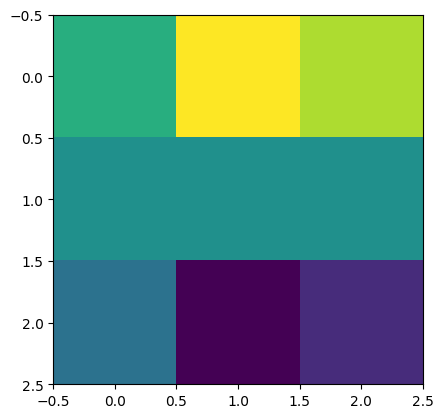

Jdet: 0.8333333333333337
Phi
[-1. -1. -1. -1. -1. -1. -1. -1. -1.]
[0.66666667 0.55555556 0.         0.77777778 1.         0.33333333 0.66666667 0.55555556 0.        ]


phi: 0.5555555555555558 -1.0000000000000004


In [154]:
# Get Jacobian field
jacobian_det_field = jacobian.sitk_jacobian_determinant(deformation, transpose_displacements=True)
print(jacobian_det_field)
plt.imshow(jacobian_det_field[0, :, :], cmap='viridis')
plt.show()

print("Jdet:", jdet(0, 2, 2, phi_xy, fixed_sample.shape))

#jacobian.surrounding_points((0, 1, 1), deformation, jacobian_det_field)

print("Phi")
print(phi_x)
print(phi_y)
print()

#compute_jacobian_determinant(deformation, (0, 1, 1), debug=True)

print()
lidx = laplacian.get_laplacian_index(0, 2, 1, fixed_sample.shape)
print("phi:", phi_xy[lidx + len(phi_xy) // 2], phi_xy[lidx])

In [155]:
lindx = laplacian.get_laplacian_index(z, y, x, fixed_sample.shape)
print(f"Laplacian index for {z, y, x}:", lindx)
print(Xd)
print(Yd)
print(XYd)
print()

# Print comparisons
print(Xd[lindx], Yd[lindx], XYd[lindx], XYd[lindx + len(Xd)])
print(phi_xy[lindx], phi_xy[lindx + len(Xd)])


print("Jdet:", jdet(0, 1, 1, phi_xy, fixed_sample.shape))

Laplacian index for (0, 1, 1): 4
[ 0.  0. -1.  0. -1.  0.  0.  0. -1.]
[0. 0. 0. 0. 1. 0. 0. 0. 0.]
[ 0.  0. -1.  0. -1.  0.  0.  0. -1.  0.  0.  0.  0.  1.  0.  0.  0.  0.]

-1.0 1.0 -1.0 1.0
-0.9999999999999998 0.9999999999999998
Jdet: 1.0


## Set up Lagrangian optimizer

In [ ]:
import sympy as sp

def generate_phi_str(b: np.ndarray): 
    phi_str = ""
    for i in range(b.shape[0]):
        if i < b.shape[0] // 2:
            phi_str += f"phi_x{i + 1}"
        else:
            phi_str += f"phi_y{(i + 1) // 2}"
        if i < b.shape[0] - 1:
            phi_str += " "
    return phi_str

phi_str = generate_phi_str(XYd)

# Define the variables
phii = sp.symbols(phi_str)

# Define the matrix A and vector B
A_ = sp.Matrix(A_expanded)
B_ = sp.Matrix(XYd)

# Define the vector phi
phi = sp.Matrix(phii)

# Define the objective function
f = (A_ * phi - B_).dot(A_ * phi - B_)  # Squared Euclidean distance

# Compute the partial derivatives
dL_dphi = [sp.diff(f, phi_i) for phi_i in phii]

# Solve the system of equations
solutions = sp.solve(dL_dphi, phii)

# Display the solutions
print("Solutions:")
if isinstance(solutions, dict):
    # Single solution case
    for i, phi_i in enumerate(phii):
        print(f"{phi_i} = {solutions[phi_i]}")
else:
    # Multiple solutions case
    for sol in solutions:
        for i, phi_i in enumerate(phii):
            print(f"{phi_i} = {sol[phi_i]}")

Solutions:
phi1 = -1.00000000000000
phi2 = -1.00000000000000
phi3 = -1.00000000000000
phi4 = -1.00000000000000
phi5 = -1.00000000000000
phi6 = -1.00000000000000
phi7 = -1.00000000000000
phi8 = -1.00000000000000
phi9 = -1.00000000000000
phi10 = 0.666666666666667
phi11 = 0.555555555555556
phi12 = 0.0
phi13 = 0.777777777777778
phi14 = 1.00000000000000
phi15 = 0.333333333333333
phi16 = 0.666666666666667
phi17 = 0.555555555555556
phi18 = 0.0


In [164]:
print(phi_x)
print(phi_y)

[-1. -1. -1. -1. -1. -1. -1. -1. -1.]
[0.66666667 0.55555556 0.         0.77777778 1.         0.33333333 0.66666667 0.55555556 0.        ]
